## Book Recommendation system

Dataset url: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

#### Read the dataset with the necessary features

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
books = pd.read_csv('BX-Books.csv', sep=';', on_bad_lines='warn', encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep=';', on_bad_lines='warn', encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', on_bad_lines='warn', encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

C:\Users\Sathi\AppData\Local\Temp\ipykernel_12080\1788259715.py:4: ParserWarning: Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

  books = pd.read_csv('BX-Books.csv', sep=';', on_bad_lines='warn', encoding="latin-1")


In [3]:
print(ratings.shape)
print(list(ratings.columns))

(174003, 3)
['userID', 'ISBN', 'bookRating']


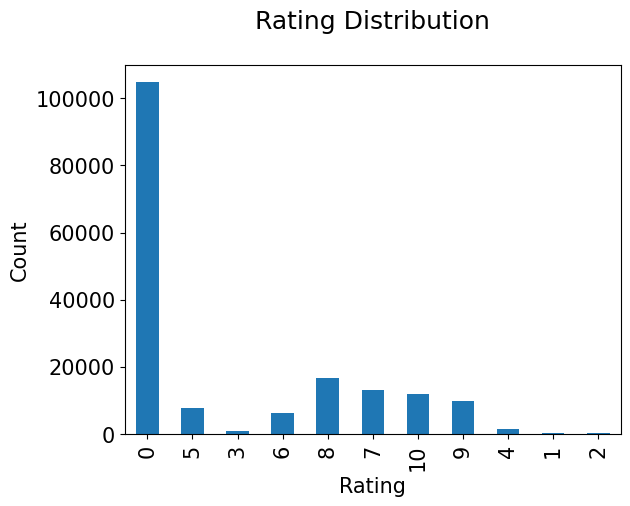

In [10]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

In [11]:
print(books.shape)
print(list(books.columns))

(61053, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [12]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


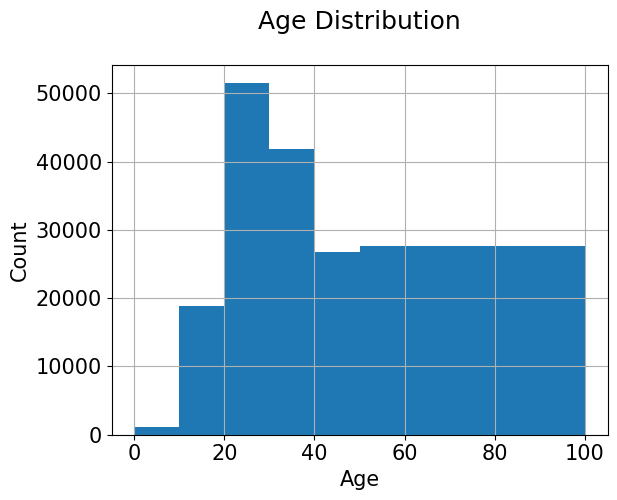

In [13]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

#### Recommendation Based on Rating Counts

In [14]:
rating_count = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
rating_count.sort_values('bookRating', ascending=False).head()

,bookRating
ISBN,
0971880107,338
0316666343,184
0385504209,124
0060928336,123
0312195516,113


The book with ISBN “0971880107” received the most rating counts. Let’s find out what book it is, and what books are in the top 5.

In [15]:
most_rated_books = pd.DataFrame(['0971880107', '0316666343', '0385504209', '0060928336', '0312195516'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, books, on='ISBN')
most_rated_books_summary

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
2,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...


### Recommendations based on correlations

We use Pearsons’R correlation coefficient to measure the linear correlation between two variables, in our case, the ratings for two books.

First, we need to find out the average rating, and the number of ratings each book received.

In [16]:
average_rating = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['bookRating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,bookRating,ratingCount
ISBN,,
0971880107,1.156805,338
0316666343,4.570652,184
0385504209,4.524194,124
0060928336,3.682927,123
0312195516,4.584071,113


Observations: In this data set, the book that received the most rating counts was not highly rated at all. As a result, if we were to use recommendations based on rating counts, we would definitely make mistakes here. So, we need to have a better system.

## To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.

In [17]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

### Rating matrix
We convert the ratings table to a 2D matrix. The matrix will be sparse because not every user rated every book.

In [18]:
ratings_pivot = ratings.pivot(index='userID', columns='ISBN').bookRating
userID = ratings_pivot.index
ISBN = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot.head()

(118, 57914)


ISBN,9022906116,0 7336 1053 6,000000000,0000000000,00000000000,0001046438,000104687X,0001047213,0001047973,000104799X,...,O77O428452,O805063196,O889950962,O9088446X,Q380708353,TBR0385495641,X000000000,ZR903CX0003,"\0432534220\""""","\2842053052\"""""
userID,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Trying to find the correlation with bones average book rating

In [20]:
bones_ratings = ratings_pivot['0316666343']
similar_to_bones = ratings_pivot.corrwith(bones_ratings)
corr_bones = pd.DataFrame(similar_to_bones, columns=['pearsonR'])
corr_bones.dropna(inplace=True)
corr_summary = corr_bones.join(average_rating['ratingCount'])
corr_summary[corr_summary['ratingCount']>=300].sort_values('pearsonR', ascending=False).head(10)

c:\Users\Sathi\anaconda3\envs\Recommendation\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Sathi\anaconda3\envs\Recommendation\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Sathi\anaconda3\envs\Recommendation\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\Sathi\anaconda3\envs\Recommendation\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Sathi\anaconda3\envs\Recommendation\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,pearsonR,ratingCount
ISBN,,
0971880107,0.284935,338


We obtained the books’ ISBNs, but we need to find out the titles of the books to see whether they make sense.

In [28]:
books_corr_to_bones = pd.DataFrame(['0316666343','0971880107'], 
                                  index=np.arange(2), columns=['ISBN'])
corr_books = pd.merge(books_corr_to_bones, books, on='ISBN')
corr_books

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
1,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
